# Clustering de documentos do Diário Oficial do Recife usando K-means e TF-IDF

Neste Jupyter Notebook, utiliza-se o TFIDF vectorizer e o MiniBatchKmeans do Sklearn para implementar um algoritmo de clustering simples. Depois visualiza-se esses clusters usando PCA e TSNE, assim como são mostradas as principais palavras-chave de cada cluster.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from nltk.corpus import stopwords
stop_words = stopwords.words('portuguese')

## Importando o dataset

Utiliza-se a biblioteca Pandas para importar o arquivo "dore_2009_proc.csv", uma coleção de documentos extraídos do Diário Oficial do Recife. 

In [3]:
data = pd.read_csv("dore_2009_proc.csv")
data.head()

,secao,conteudo,int_label
0,Poder Executivo,LEI Nº 17.597 /2009 EMENTA: DISPÕE SOBRE A SE...,0
1,Poder Executivo,DECRETO Nº 25.024 DE 30 DE DEZEMBRODE 2009 EM...,0
2,Poder Executivo,PORTARIA Nº 3130 DE 30 DE DEZEMBRO DE 2009 O...,0
3,Poder Executivo,º 18012078. PORTARIA Nº 3137 DE 30 DE DEZEM...,0
4,Poder Executivo,"esenvolvimento Urbano e Ambiental, a contar da...",0


## Extraindo palavras-chave

Utiliza-se o TfidfVectorizer do Sklearn para a extração de palavras-chave, elas serão utilizadas para formar os clusters.

In [4]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = stop_words
)
tfidf.fit(data.conteudo)
text = tfidf.transform(data.conteudo)

## Encontrando a quantidade ideal de clusters

No código abaixo, calcula-se o Sum of Squared Error (SSE) para vários tamanhos de cluster, neste caso até 14, e depois procura-se o "cotovelo" onde o SSE começa a se estabilizar. 

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


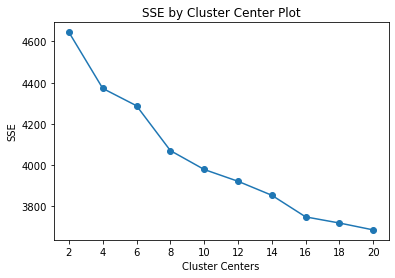

In [5]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [6]:
clusters = MiniBatchKMeans(n_clusters=16, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

## Visualização dos clusters

Abaixo, visualiza-se os clusters gerados pelo algoritmo K-means. Um gráfico usa o PCA, que é melhor na captura da estrutura global dos dados. O outro usa TSNE, que é melhor em capturar relações entre vizinhos.

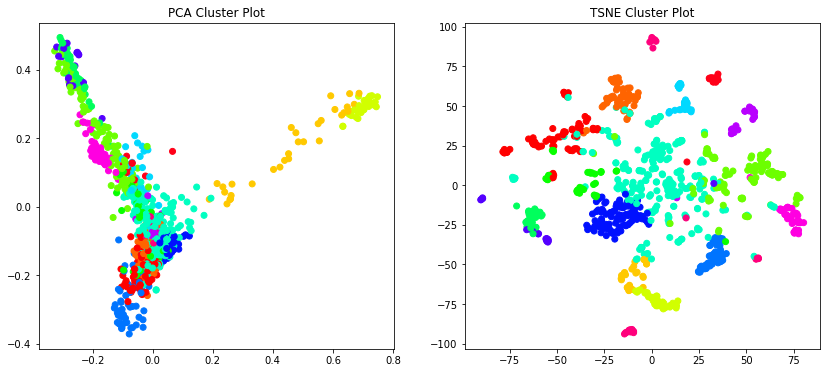

In [10]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=1000, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

## Principais palavras-chave

Por fim, percorre-se os clusters e são impressas as principais palavras-chave com base na pontuação do TFIDF para ver se é possível identificar alguma tendência. Faz-se isso calculando um valor médio entre todas as dimensões no Pandas, agrupadas pelo rótulo do cluster. 

In [8]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
prorrogação,reais,prazo,2009,nº,extrato,aditivo,objeto,contrato,termo

Cluster 1
empresa,inexigibilidade,pregão,00,objeto,nº,recife,ltda,2009,licitação

Cluster 2
mariano,requerimento,aprovado,vereadores,presidente,discussão,senhor,2009,autoria,vereador

Cluster 3
sr,indicação,vereador,sentido,dirigindo,única,aprovado,requerimento,discussão,autoria

Cluster 4
ofício,prefeito,uso,contar,contido,atribuições,portaria,matrícula,2009,nº

Cluster 5
presidente,municipal,nº,cidadania,instituto,iasc,2009,cmas,assistência,social

Cluster 6
nº,municipal,140121780,código,2009,lotação,aula,rpa,mat,escola

Cluster 7
portaria,pe,00,09,municipal,lei,nº,2009,recife,art

Cluster 8
00,código,99,câmara,símbolo,cargo,resolução,parlamentar,comissionado,plc

Cluster 9
suplementar,art,recursos,artigo,000,0100,90,secretaria,00,ft

Cluster 10
evento,além,prefeitura,disse,última,feira,recife,costa,joão,prefeito

Cluster 11
rpa,lotação,140121780,daquelas,outubro,senhor,exmo,portaria,nº,2009

Cluster 12

## Considerações finais

You can see that we have a pretty good result. Topics including exploitation of children, tax fraud, civil rights, and environmental issues can be inferred from the top keywords. Other interesting approaches to this might include LDA topic modeling or possibly working with pre-trained word embeddings.